# Targeted Investigation into DEGs
Looking closer into DEGs with gene targets/genes of interest

# Phase 2 vs. Phase 2

## 0. load libraries

In [2]:
library(tidyverse) # for dplyr, stringr, ggplot
library(KEGGREST) # for KEGG pathways
library(multcompView) # for stat labels on ggplot
library(GO.db)
library(AnnotationDbi)

## 1. load CSVs

### DEGs

In [3]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

head(files)

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bb_cc.csv"
[2] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_bb.csv"
[3] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_cc.csv"
[4] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_hc.csv"
[5] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bc_wc.csv"
[6] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs/DEG_bh_ch.csv"

In [4]:
names(files) <- gsub("^DEG_", "", tools::file_path_sans_ext(basename(files)))
deg_list <- lapply(files, read.csv)
names(deg_list)
length(deg_list) # 35 pairwise comparisons

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

[1] 35

### all genes

In [5]:
# get list of files
all_files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes',
    pattern = '\\.csv$',
    full.names = TRUE
    )

head(all_files)

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv"
[2] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_bb.csv"
[3] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cc.csv"
[4] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_hc.csv"
[5] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_wc.csv"
[6] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_ch.csv"

In [7]:
names(all_files) <- tools::file_path_sans_ext(basename(all_files))
all_list <- lapply(all_files, read.csv)
names(all_list)
length(all_list) # 35 pairwise comparisons

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

[1] 35

## 2. Growth Genes

### Chitin Genes
In both vs. control there are four gene sets that are over-represented in relation to chitin (chitin binding, chitinase activity, chitin catabolic process, and polysaccharide catabolic process)

Want to pull these out, take a closer look, look at these in other comparisons against the both treatment and see if these genes are always affected

In [22]:
# read in gene ID to GO term file
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')

# expand df so every row contains one GO and one gene ID
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ";")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name) 

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0000981,GO:0000981,"DNA-binding transcription factor activity, RNA polymerase II-specific"
GO:0004750,GO:0004750,D-ribulose-phosphate 3-epimerase activity
GO:0003682,GO:0003682,chromatin binding
GO:0004062,GO:0004062,aryl sulfotransferase activity
GO:0005743,GO:0005743,mitochondrial inner membrane


In [23]:
chitinGO <- term2name[grep('chitin', term2name$name, ignore.case = TRUE),]
chitinGO

,term,name
,<chr>,<chr>
GO:0004100,GO:0004100,chitin synthase activity
GO:0004568,GO:0004568,chitinase activity
GO:0008061,GO:0008061,chitin binding


In [24]:
# pull out genes related to chitinase activity
# GO:0004568
chitin_genes <- term2gene %>%
inner_join(chitinGO, by = 'term') %>%
distinct(gene, term, name)

chitin_genes

gene,term,name
<chr>,<chr>,<chr>
LOC111109754,GO:0004100,chitin synthase activity
LOC111109745,GO:0004100,chitin synthase activity
LOC111137818,GO:0004568,chitinase activity
LOC111119842,GO:0004568,chitinase activity
LOC111119841,GO:0004568,chitinase activity
LOC111118377,GO:0004568,chitinase activity
LOC111126623,GO:0008061,chitin binding
LOC111126666,GO:0008061,chitin binding
LOC111125904,GO:0008061,chitin binding


In [26]:
# combining all dfs into one
combined.df <- do.call(rbind, deg_list)
dim(combined.df)

# pulling out only genes related to chitin
chitin_all <- combined.df[chitin_genes$gene %in% combined.df$Gene,]
dim(chitin_all)
head(chitin_all)

[1] 8335  104

[1] 807 104

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,B1_W5_O50,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
bb_cc.8,LOC111099906,5.299119,16.906072,3.2701514,-5.381801,7.374433e-08,6.606076e-05,1.310678e-04,0.000000,0.0000,⋯,28.60921,0.00000,0.000000,0.00000,13.804010,2.216526,0.00000,0.00000,CC vs. BB,BB
bb_cc.20,LOC111123476,5.540884,20.773054,3.6940342,-5.817735,5.965034e-09,6.934038e-06,9.644104e-06,2.812588,0.0000,⋯,0.00000,0.00000,3.679626,21.10826,0.000000,1.108263,0.00000,0.00000,CC vs. BB,BB
bb_cc.21,LOC111126872,1163.025321,1.611773,0.4103133,-5.073767,3.900159e-07,2.479076e-04,6.780384e-03,2682.271393,816.3202,⋯,541.08725,970.18739,975.101018,1183.11793,1043.353114,651.658621,435.77959,801.19908,CC vs. BB,BB
bb_cc.39,LOC111133744,126.602184,-1.314713,1.6580459,3.752307,1.752148e-04,3.740644e-02,1.898603e-01,13.125411,232.6662,⋯,11.19491,47.15492,24.837479,42.21652,13.804010,17.732207,22.59598,25.50236,CC vs. BB,CC
bb_cc.51,LOC111138424,8.411075,-17.238067,3.9094354,4.978206,6.417619e-07,3.595281e-04,1.421333e-03,0.000000,0.0000,⋯,0.00000,0.00000,0.000000,0.00000,4.601337,0.000000,67.78794,0.00000,CC vs. BB,CC
bb_cc.52,LOC111132298,16.259494,17.328349,3.8635372,-5.009598,5.454380e-07,3.219351e-04,9.804195e-04,1.875059,0.0000,⋯,0.00000,14.04615,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,CC vs. BB,BB


there are 2445 DEGs related to chitin in all phase 2 comparisons!

In [27]:
# add col that denotes pair with Both treatment
chitin_all2 <- chitin_all %>%
mutate(pair_B = if_else(
    grepl('b', rownames(.)), 'Yes', 'No')
       )

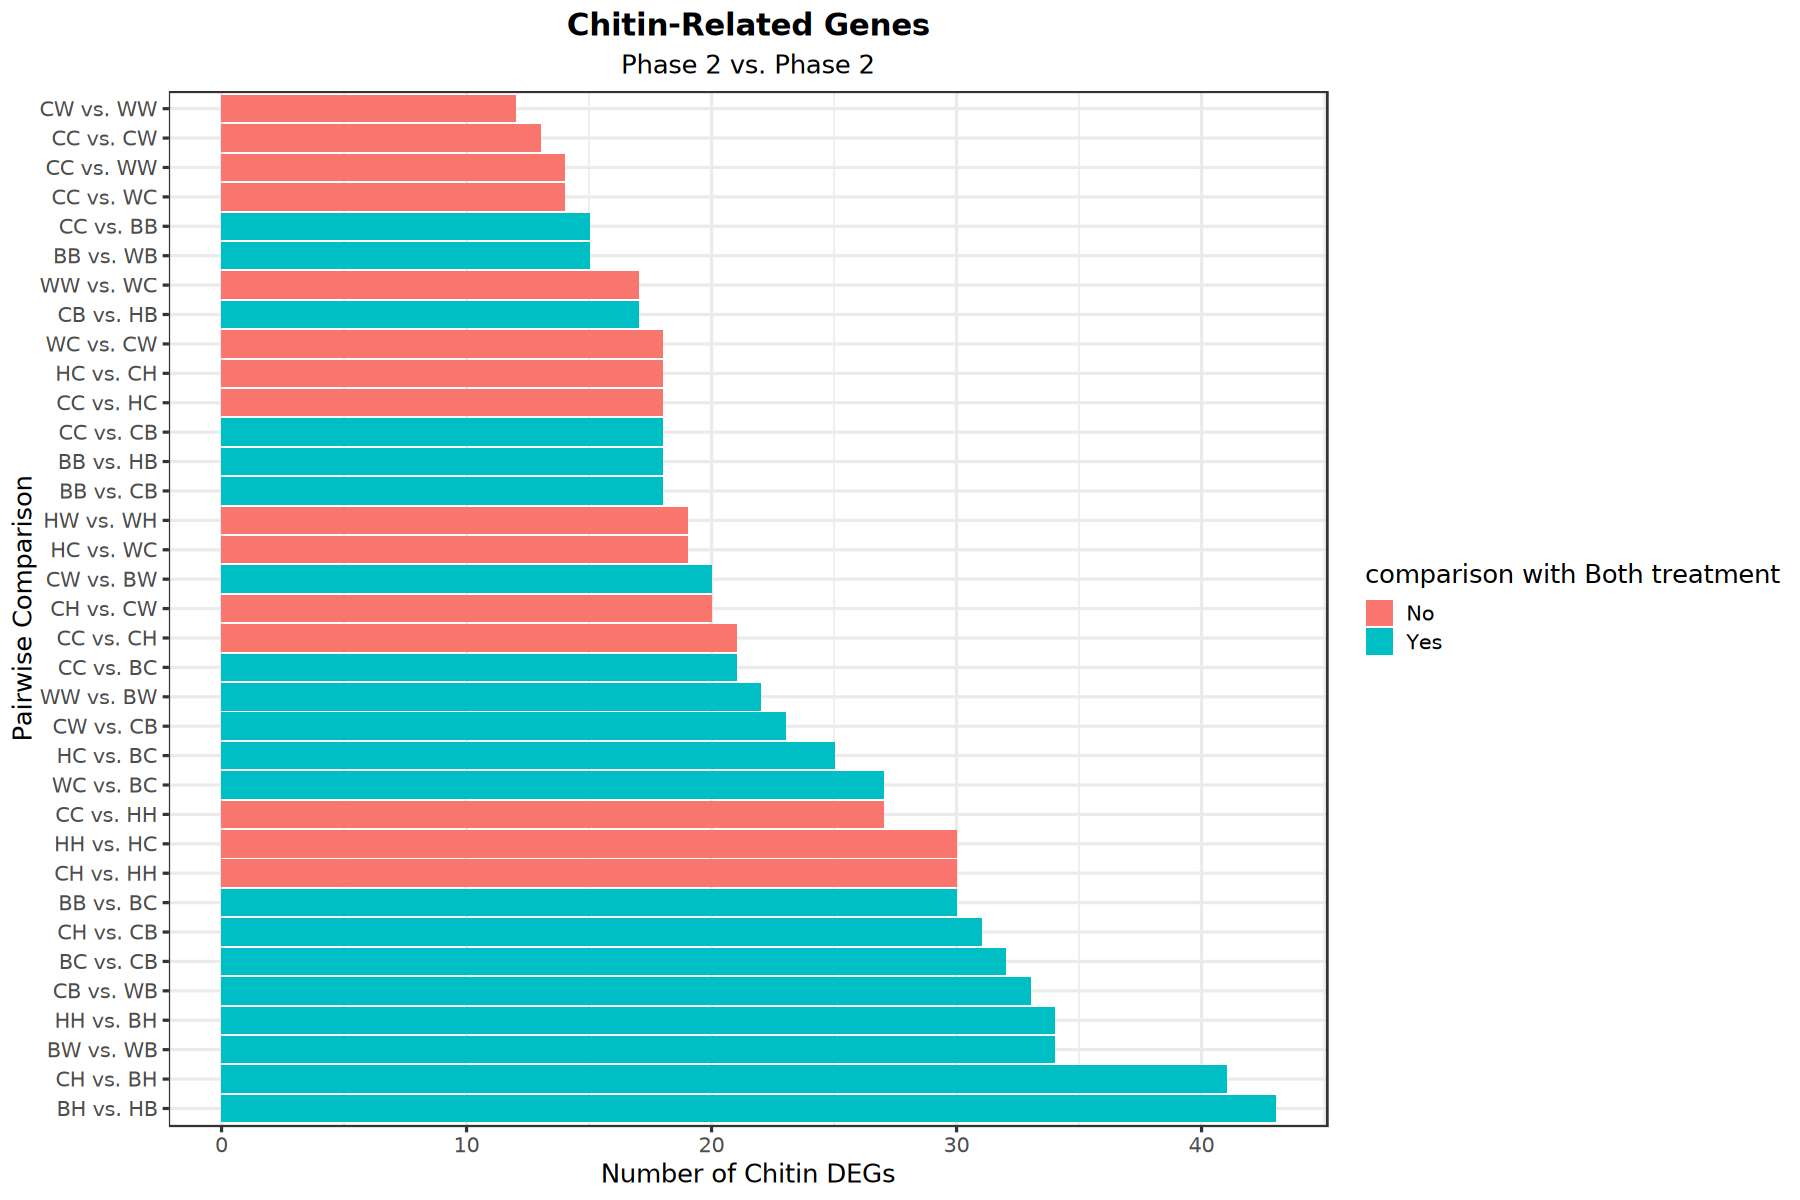

In [28]:
options(repr.plot.width=15, repr.plot.height=10)

chitin_bar <- ggplot(chitin_all2, aes(x = reorder(pair, -table(pair)[pair]), fill = pair_B)) +
geom_bar(stat = 'count') + 
#scale_fill_brewer(palette='Set2') + 
theme_bw(base_size=15) +
labs(title = 'Chitin-Related Genes',
     subtitle = 'Phase 2 vs. Phase 2',
     x = 'Pairwise Comparison',
     y = 'Number of Chitin DEGs',
    fill = 'comparison with Both treatment') +
theme(plot.title = element_text(face = 'bold', hjust = 0.5),
     plot.subtitle = element_text(hjust = 0.5)) + 
coord_flip() 

chitin_bar

In [29]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/plots/chitin.genes_bar.pdf', chitin_bar, width = 15, height = 10)

In [30]:
# add col that denotes pair with Both treatment
chitin_all2 <- chitin_all %>%
mutate(pair_B = if_else(
    grepl('b', rownames(.)), 'contains both treatment', 'no both treatment')
       )

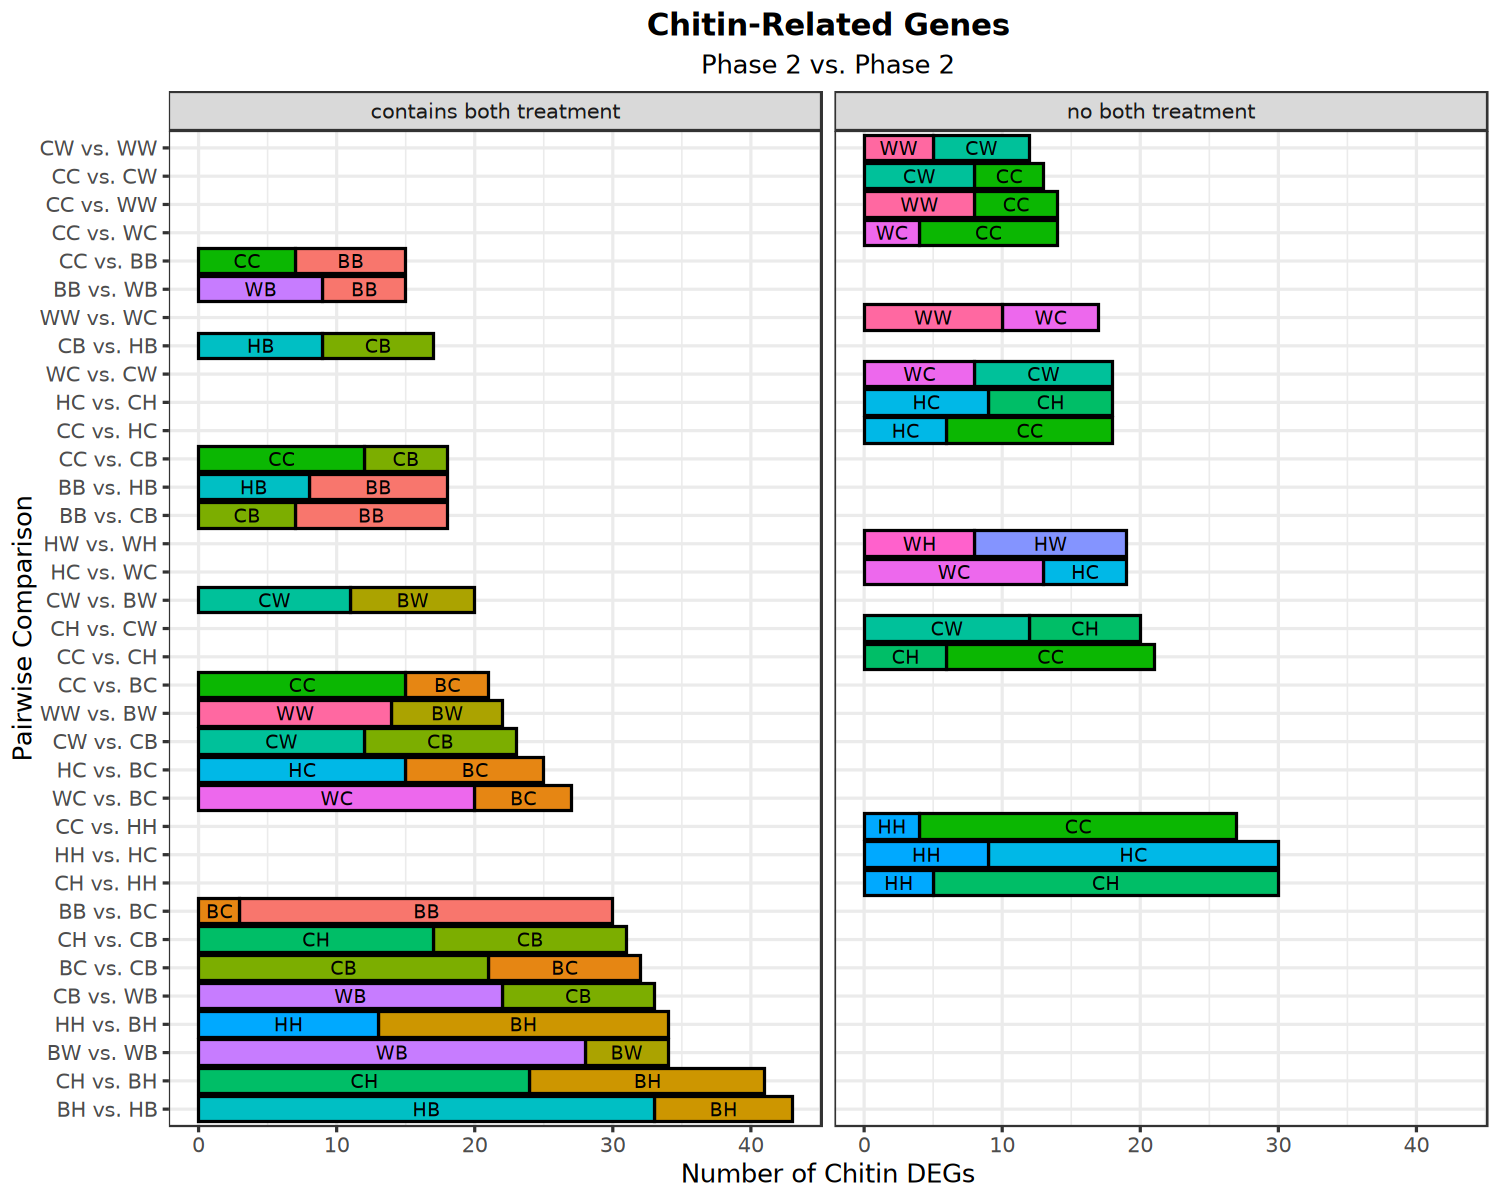

In [31]:
options(repr.plot.width=12.5, repr.plot.height=10)

chitin_bar <- ggplot(chitin_all2, aes(x = reorder(pair, -table(pair)[pair]), fill = DEG_group)) +
geom_bar(stat = 'count', col = 'black') + 
facet_wrap(~pair_B) + 
#scale_fill_brewer(palette='Set2') + 
theme_bw(base_size=15) +
labs(title = 'Chitin-Related Genes',
     subtitle = 'Phase 2 vs. Phase 2',
     x = 'Pairwise Comparison',
     y = 'Number of Chitin DEGs',
    fill = 'Treatment with higher expression') +
geom_text(
    stat = "count",
    aes(label = DEG_group),
    position = position_stack(vjust = 0.5),
    color = "black",
    size = 4
  ) +
theme(legend.position = 'none',
    plot.title = element_text(face = 'bold', hjust = 0.5),
     plot.subtitle = element_text(hjust = 0.5)) + 
coord_flip() 

chitin_bar

In [32]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/plots/chitin.genesDETAILED_bar.pdf', chitin_bar, width = 12.5, height = 10)

## 3. Stress-related genes

### HSP70

using normalized counts - these are attached to the DESeq results, so I can choose any csv to look at bc they're all the same

In [8]:
norm_counts <- all_list$bb_cc %>%
dplyr::select(-c( baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, svalue))

head(norm_counts)

,Gene,B1_B1_O01,B1_W5_O50,B2_B5_O51,B2_C4_O40,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,B3_W1_O06,⋯,W4_W5_G56,W5_B2_G21,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111116054,1.875059,5.965799,9.44740,7.830485,0.00000,11.75544,14.436329,9.311552,7.673523,⋯,4.336105,2.452846,11.19491,2.006592,7.359253,5.277065,2.300668,21.05700,1.075999,0.0000
2,LOC111126949,829.713451,474.281013,617.85999,509.851567,453.26645,419.66928,325.473593,558.693109,621.555373,⋯,230.897604,544.531781,506.25864,742.439160,650.373981,428.497663,480.839693,469.90350,302.355713,636.4963
3,LOC111110729,60.001877,92.469883,59.51862,87.005387,87.87819,115.20333,154.206239,187.265653,97.563365,⋯,128.999131,62.138762,87.07151,149.491128,111.308701,121.372491,144.942108,119.69240,136.651870,226.3334
4,LOC111112434,10.312823,1.988600,0.00000,1.740108,13.87550,17.63316,6.561968,37.246207,1.096218,⋯,6.504158,0.000000,13.68267,6.019777,3.679626,0.000000,2.300668,17.73221,8.607992,0.0000
5,LOC111120752,337.510556,334.084739,402.45926,305.388908,272.88491,326.80129,499.365735,385.912092,202.800254,⋯,421.686235,286.165350,446.55246,346.137176,402.919100,293.404804,330.145914,461.03739,358.307660,456.9172
6,LOC111128944,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,⋯,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000


In [9]:
hsp70 <- norm_counts %>%
  dplyr::filter(Gene == "LOC111137579") %>%
  dplyr::select(-Gene) %>%      # remove gene column
  t() %>%                   # transpose
  as.data.frame() %>%       # matrix → data.frame
  rownames_to_column("Sample") %>%
  dplyr::rename(norm_counts = V1)

dim(hsp70)
head(hsp70)

[1] 94  2

,Sample,norm_counts
,<chr>,<dbl>
1,B1_B1_O01,334.6980
2,B1_W5_O50,660.2151
3,B2_B5_O51,652.8154
4,B2_C4_O40,319.3098
5,B3_B4_O41,698.4004
6,B3_C3_O30,429.0736


In [10]:
metaData <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
mutate(complete_trtmt  = paste0(Phase1_treatment, '_', Phase2_treatment)) %>%
filter(!is.na(Phase2_treatment)) %>% # remove phase 1 samples
dplyr::select(Sample, Phase1_temp, Phase1_DO, Phase1_treatment, Phase2_temp, Phase2_DO, Phase2_treatment, complete_trtmt)

head(metaData)

,Sample,Phase1_temp,Phase1_DO,Phase1_treatment,Phase2_temp,Phase2_DO,Phase2_treatment,complete_trtmt
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,B1_B1_O01,warm,hypoxic,both,warm,hypoxic,both,both_both
2,B1_W5_O50,warm,hypoxic,both,warm,normoxic,warm,both_warm
3,B2_B5_O51,warm,hypoxic,both,warm,hypoxic,both,both_both
4,B2_C4_O40,warm,hypoxic,both,ambient,normoxic,control,both_control
5,B3_B4_O41,warm,hypoxic,both,warm,hypoxic,both,both_both
6,B3_C3_O30,warm,hypoxic,both,ambient,normoxic,control,both_control


In [11]:
hsp70.df <- merge(hsp70, metaData, by = 'Sample')
head(hsp70.df)

,Sample,norm_counts,Phase1_temp,Phase1_DO,Phase1_treatment,Phase2_temp,Phase2_DO,Phase2_treatment,complete_trtmt
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,B1_B1_O01,334.6980,warm,hypoxic,both,warm,hypoxic,both,both_both
2,B1_W5_O50,660.2151,warm,hypoxic,both,warm,normoxic,warm,both_warm
3,B2_B5_O51,652.8154,warm,hypoxic,both,warm,hypoxic,both,both_both
4,B2_C4_O40,319.3098,warm,hypoxic,both,ambient,normoxic,control,both_control
5,B3_B4_O41,698.4004,warm,hypoxic,both,warm,hypoxic,both,both_both
6,B3_C3_O30,429.0736,warm,hypoxic,both,ambient,normoxic,control,both_control


In [18]:
# two-way anova
hsp.aov <- aov(norm_counts ~ Phase1_treatment * Phase2_treatment, data = hsp70.df)
summary(hsp.aov)

                                  Df  Sum Sq Mean Sq F value Pr(>F)
Phase1_treatment                   3   52444   17481   0.387  0.763
Phase2_treatment                   3  285012   95004   2.104  0.106
Phase1_treatment:Phase2_treatment  9  215197   23911   0.530  0.849
Residuals                         78 3521306   45145               

In [19]:
# tukey post hoc
hsp.tukey <- TukeyHSD(hsp.aov)
hsp.tukey

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = norm_counts ~ Phase1_treatment * Phase2_treatment, data = hsp70.df)

$Phase1_treatment
                     diff       lwr      upr     p adj
control-both    -48.12650 -210.8917 114.6387 0.8649684
hypoxic-both    -16.73383 -181.2215 147.7538 0.9932804
warm-both       -58.86612 -221.6313 103.8991 0.7782449
hypoxic-control  31.39267 -131.3725 194.1579 0.9573474
warm-control    -10.73962 -171.7640 150.2847 0.9980765
warm-hypoxic    -42.13229 -204.8975 120.6329 0.9045575

$Phase2_treatment
                      diff       lwr        upr     p adj
control-both     -71.38091 -234.1461  91.384296 0.6590525
hypoxic-both    -154.32123 -317.0864   8.443984 0.0695185
warm-both        -57.73822 -218.7626 103.286137 0.7827001
hypoxic-control  -82.94031 -247.4280  81.547329 0.5507599
warm-control      13.64270 -149.1225 176.407905 0.9962084
warm-hypoxic      96.58301  -66.1822 259.348217 0.4085864

$`Phase

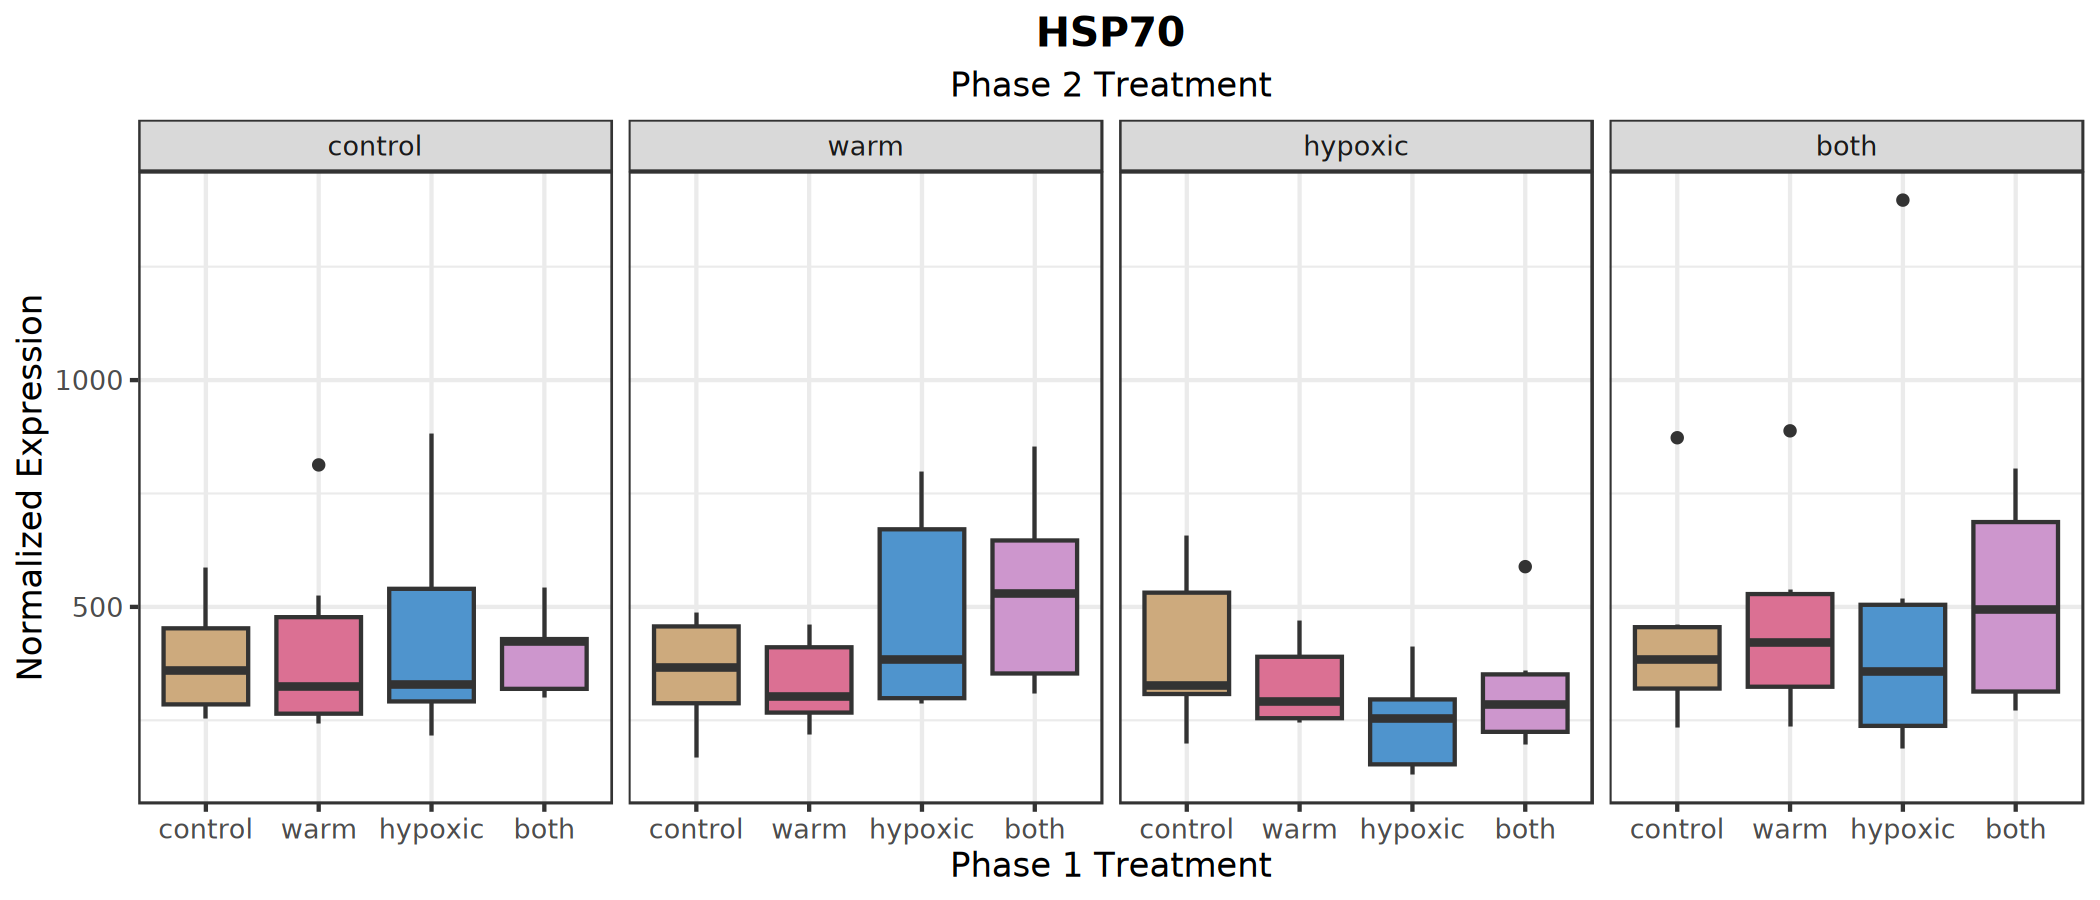

In [12]:
options(repr.plot.width=17.5, repr.plot.height=7.5)

# add factor to treatments for plotting order
hsp70.df$Phase1_treatment <- factor(hsp70.df$Phase1_treatment, c('control', 'warm', 'hypoxic', 'both'))
hsp70.df$Phase2_treatment <- factor(hsp70.df$Phase2_treatment, c('control', 'warm', 'hypoxic', 'both'))

# plotting
hsp_box <- ggplot(hsp70.df, aes(x=Phase1_treatment, y=norm_counts, fill = Phase1_treatment)) +
geom_boxplot() + 
facet_wrap(~Phase2_treatment, nrow = 1) + 
scale_fill_manual(values = c("control" = "burlywood3", "hypoxic" = "steelblue3", "warm" = "palevioletred", "both" = "plum3")) + 
theme_bw(base_size = 20) +
labs(title = 'HSP70',
     subtitle = 'Phase 2 Treatment',
     x = 'Phase 1 Treatment',
     y = 'Normalized Expression') +
theme(legend.position = 'none',
     plot.title = element_text(hjust = 0.5, face = 'bold'),
     plot.subtitle = element_text(hjust = 0.5))

hsp_box

In [21]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/plots/hsp70_normExpr_boxplot.pdf', hsp_box, width = 17.5, height = 7.5)